In [1]:
import pandas as pd

df = pd.read_csv('input/df_quarterly_macro.csv')
df = df[df['Year'] <= 2019]
df = df.rename(columns={"Code" : "isocode"})

# Mapping from quarter number to month (Q1 = March, Q2 = June, etc.)
quarter_month_map = {1: 3, 2: 6, 3: 9, 4: 12}
df["month"] = df["Quarter"].map(quarter_month_map)
df["date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["month"].astype(str) + "-01")
df.drop(columns="month", inplace=True)  # optional cleanup
df = df.drop(columns=["Country", "Year", "Quarter"])

# Selecting relevant columns
static_cols = ['isocode', 'date', '1DLGDP']
#lag_cols = df.columns[df.columns.str.contains(r'_lag\d+$')]
lag_cols = df.columns[df.columns.str.endswith('_lag1') | df.columns.str.endswith('_lag2')]
cols_to_include = static_cols + lag_cols.to_list()
df = df[cols_to_include].copy()
df = df.reset_index(drop=True)
print("Number of units: ", df["isocode"].nunique())
df

Number of units:  49


,isocode,date,1DLGDP,1DLGDP_lag1,1DLGDP_lag2,1DLINDPRO_lag1,2DLINDPRO_lag1,1DLMANPRO_lag1,1DLRETAIL_lag1,MPR_lag1,...,RW_SPREAD_1D_lag2,RW_FFUNDS_1D_lag1,RW_FFUNDS_1D_lag2,RW_HPI_1DL_lag1,RW_HPI_1DL_lag2,RW_HPI_2DL_lag2,RW_TRADE_1DL_lag1,RW_TRADE_2DL_lag1,RW_WTI_1DL_lag1,RW_WTI_2DL_lag1
0,ARG,1997-03-01,2.078385,0.657755,0.657787,0.533193,-0.010754,0.587473,0.633271,6.026856,...,0.01833,-0.002829,-0.002995,0.865185,0.865399,-0.004953,0.768611,-0.036150,1.032762,-0.123308
1,ARG,1997-06-01,1.476696,2.078385,0.657787,0.533193,-0.010754,0.587473,0.633271,5.650000,...,0.01833,0.000000,-0.002995,-0.364861,0.865399,-0.004953,0.768611,-0.036150,-7.501409,-17.260051
2,ARG,1997-09-01,2.485988,1.476696,2.078385,0.533193,-0.010754,0.587473,0.633271,5.736667,...,0.01833,0.240000,0.000000,0.350853,-0.364861,-0.631360,0.768611,-0.036150,-13.722687,-6.221277
3,ARG,1997-12-01,1.342418,2.485988,1.476696,0.533193,-0.010754,0.587473,0.633271,7.126667,...,-0.10000,0.010000,0.240000,0.739762,0.350853,0.715714,0.768611,-0.036150,-0.604231,13.118455
4,ARG,1998-03-01,0.516006,1.342418,2.485988,0.533193,-0.010754,0.587473,0.633271,8.723333,...,-0.07000,-0.020000,0.010000,0.540879,0.739762,0.388909,0.768611,-0.036150,0.804833,1.409065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4503,USA,2018-12-01,0.181616,0.719442,0.694924,0.838772,-0.309375,0.386628,0.633271,1.958333,...,0.01000,0.190000,0.290000,0.717932,0.876029,-0.262795,0.927117,0.339235,2.352025,-5.531121
4504,USA,2019-03-01,0.541243,0.181616,0.719442,0.129218,-0.709554,-0.434406,0.633271,2.208333,...,0.05000,0.290000,0.190000,0.390802,0.717932,-0.158097,-0.526443,-1.453560,-15.021240,-17.373265
4505,USA,2019-06-01,0.670759,0.541243,0.181616,-0.935471,-1.064690,-1.183483,0.633271,2.375000,...,0.59000,0.180000,0.290000,0.821697,0.390802,-0.327131,-0.641851,-0.115408,-8.978935,6.042305
4506,USA,2019-09-01,0.886030,0.670759,0.541243,-0.608246,0.327226,-0.805074,0.633271,2.375000,...,0.17000,0.000000,0.180000,0.844512,0.821697,0.430896,-0.048305,0.593545,8.828747,17.807681


In [2]:
isocode_list = ["ARG", "BEL", "BRA", "CZE", "FRA", "DEU", "ITA", "PER", "ESP", "USA"]

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import pandas as pd
from OptimalPanel.optimizer import OptimalBundleRL

for isocode in isocode_list:
    
    # --- Configuration ---
    unit_col = 'isocode'
    time_col = 'date'
    target_col = '1DLGDP'
    target_unit = isocode
    feature_cols = df.columns.difference([unit_col, time_col, target_col])
    forecast_times = list(pd.date_range(start="2015-03-01", end="2019-12-01", freq="3MS"))
    total_epochs = 1000

    # --- Cutoff for similarity training ---
    train_cutoff = pd.to_datetime("2012-12-31")
    test_start = pd.to_datetime("2013-01-01")
    test_end = pd.to_datetime("2014-12-31")

    # --- Target test set ---
    target_test_df = df[(df[unit_col] == target_unit) & (df[time_col].between(test_start, test_end))]
    X_target_test = target_test_df[feature_cols]
    y_target_test = target_test_df[target_col]

    # --- Train models for each country and compute similarity ---
    country_rmse = {}

    for iso in df[unit_col].unique():
        train_df = df[(df[unit_col] == iso) & (df[time_col] <= train_cutoff)]
        if len(train_df) < 5 or len(X_target_test) == 0:
            continue
        
        X_train = train_df[feature_cols]
        y_train = train_df[target_col]

        model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_target_test)
        rmse = sqrt(mean_squared_error(y_target_test, y_pred))
        country_rmse[iso] = rmse

    if len(country_rmse) < 5:
        print(f"⚠️ Skipping {target_unit} — insufficient valid donors")
        continue

    # --- Convert to similarity ---
    similarity_rmse_df = pd.DataFrame.from_dict(country_rmse, orient='index', columns=['RMSE'])
    similarity_rmse_df = similarity_rmse_df.sort_values(by='RMSE')

    donor_isos = similarity_rmse_df.index.drop(target_unit, errors='ignore').tolist()
    similarity_scores = 1 / (1 + similarity_rmse_df.loc[donor_isos, 'RMSE'].values)
    sim_tensor = torch.tensor(similarity_scores, dtype=torch.float32)

    print(f"\n🔍 Target: {target_unit} — Top donor scores:")
    for iso, score in zip(donor_isos[:10], similarity_scores[:10]):
        print(f"  {iso}: {score:.4f}")  

    # --- RL Optimization ---
    rl = OptimalBundleRL(
        df=df,
        unit_col=unit_col,
        time_col=time_col,
        target_col=target_col,
        feature_cols=feature_cols,
        target_unit=target_unit,
        donor_units=donor_isos,
        similarities=sim_tensor,
        forecast_times=forecast_times
    )

    rl.train(
        n_epochs=total_epochs,
        save=True,
        save_path=f"results/quarterly/results_{target_unit}.pkl"
    )


🔍 Target: ARG — Top donor scores:
  HRV: 0.5747
  BGR: 0.5678
  ITA: 0.5660
  GRC: 0.5563
  GBR: 0.5473
  JPN: 0.5259
  CHL: 0.5247
  FRA: 0.5145
  DEU: 0.5084
  NLD: 0.5009
Epoch 0 — Avg MSE: 2.5816, Bundle Size: 33
Epoch 10 — Avg MSE: 2.2795, Bundle Size: 20
Epoch 20 — Avg MSE: 2.6176, Bundle Size: 29
Epoch 30 — Avg MSE: 2.4594, Bundle Size: 21
Epoch 40 — Avg MSE: 2.5209, Bundle Size: 25
Epoch 50 — Avg MSE: 2.5984, Bundle Size: 24
Epoch 60 — Avg MSE: 2.1632, Bundle Size: 23
Epoch 70 — Avg MSE: 2.3041, Bundle Size: 23
Epoch 80 — Avg MSE: 2.5477, Bundle Size: 27
Epoch 90 — Avg MSE: 2.4532, Bundle Size: 22
Epoch 100 — Avg MSE: 2.3337, Bundle Size: 21
Epoch 110 — Avg MSE: 2.0697, Bundle Size: 16
Epoch 120 — Avg MSE: 2.2055, Bundle Size: 14
Epoch 130 — Avg MSE: 2.6571, Bundle Size: 21
Epoch 140 — Avg MSE: 2.6483, Bundle Size: 19
Epoch 150 — Avg MSE: 2.1159, Bundle Size: 21
Epoch 160 — Avg MSE: 2.7086, Bundle Size: 25
Epoch 170 — Avg MSE: 2.3262, Bundle Size: 17
Epoch 180 — Avg MSE: 2.628

## Interpretation

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_results_and_plot(results_dir="results/quarterly", top_n_donors=20, save=False, directory="results"):
    benchmark_data = []

    for filename in os.listdir(results_dir):
        if filename.endswith(".pkl") and filename.startswith("results_"):
            filepath = os.path.join(results_dir, filename)
            with open(filepath, "rb") as f:
                results = pickle.load(f)

            target_unit = results["target_unit"]
            print(f"📦 Loaded {filename}")

            # --- Plot learning curve ---
            plt.figure()
            plt.plot(results["avg_mse_per_epoch"], label="RL MSE")
            plt.xlabel("Epoch")
            plt.ylabel("MSE")
            plt.title(f"Learning Curve: {target_unit}")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            if save:
                iso_path = f"{directory}/{target_unit}_learning_curve.pdf"
                plt.savefig(iso_path, format="pdf", bbox_inches="tight", dpi=300)
                print(f"✅ Plot saved to {iso_path}")
            plt.show()

            # --- Plot donor inclusion probabilities ---
            final_scores = {
                iso: probs[-1]
                for iso, probs in results["inclusion_probs_by_donor"].items()
                if len(probs) > 0
            }
            top_donors = sorted(final_scores.items(), key=lambda x: -x[1])[:top_n_donors]

            plt.figure()
            for iso, _ in top_donors:
                plt.plot(results["inclusion_probs_by_donor"][iso], label=iso)

            plt.xlabel("Epoch")
            plt.ylabel("Inclusion Probability")
            plt.title(f"Top {top_n_donors} Donor Inclusion Probs — {target_unit}")
            plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
            plt.grid(True)
            plt.tight_layout()
            if save:
                iso_path = f"{directory}/{target_unit}_donors_probabilities.pdf"
                plt.savefig(iso_path, format="pdf", bbox_inches="tight", dpi=300)
                print(f"✅ Plot saved to {iso_path}")
            plt.show()

            # --- Collect benchmark results ---
            benchmarks = results.get("benchmarks", {})
            if benchmarks:
                benchmark_data.append({
                    "country": target_unit,
                    "AR(1)": benchmarks.get("ar1_mse", None),
                    "Solo RF": benchmarks.get("solo_rf_mse", None),
                    "Full Panel RF": benchmarks.get("full_panel_rf_mse", None),
                    "Best Bundle RF": benchmarks.get("best_bundle_rf_mse", None),
                })

    return pd.DataFrame(benchmark_data)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_benchmark_summary(benchmark_df, save=False, save_path="benchmark_summary.pdf"):
    if benchmark_df.empty:
        print("No benchmark data to plot.")
        return

    # Normalize by AR(1) MSE for each country
    df_relative = benchmark_df.copy()
    for idx, row in df_relative.iterrows():
        ar1_mse = row["AR(1)"]
        if ar1_mse == 0:
            continue  # avoid division by zero
        for col in df_relative.columns:
            if col != "country":
                df_relative.at[idx, col] = row[col] / ar1_mse
        df_relative.at[idx, "AR(1)"] = 1.0  # set AR(1) to baseline

    # Melt for long format
    df_melted = df_relative.melt(id_vars="country", var_name="Method", value_name="Relative MSE")

    plt.figure(figsize=(14, 6))
    for method in df_melted["Method"].unique():
        subset = df_melted[df_melted["Method"] == method]
        plt.plot(subset["country"], subset["Relative MSE"], marker="o", label=method)

    plt.xticks(rotation=90)
    plt.ylabel("Relative MSE")
    plt.title("Benchmark Comparison Across Countries")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(save_path, format="pdf", bbox_inches="tight", dpi=300)
        print(f"✅ Plot saved to {save_path}")
    plt.show()

def plot_benchmark_boxplot(benchmark_df, save=False, save_path="benchmark_boxplot.pdf"):
    if benchmark_df.empty:
        print("No benchmark data to plot.")
        return

    # Normalize by AR(1) MSE for each country
    df_relative = benchmark_df.copy()
    for idx, row in df_relative.iterrows():
        ar1_mse = row["AR(1)"]
        if ar1_mse == 0:
            continue  # avoid division by zero
        for col in df_relative.columns:
            if col != "country":
                df_relative.at[idx, col] = row[col] / ar1_mse
        df_relative.at[idx, "AR(1)"] = 1.0  # set AR(1) to baseline

    # Melt for long format
    df_melted = df_relative.melt(id_vars="country", var_name="Method", value_name="Relative MSE")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x="Method", y="Relative MSE", palette="Set2")
    plt.ylabel("Relative MSE")
    plt.title("Distribution of Relative MSE by Method")
    plt.grid(True, axis='y')

    if save:
        plt.savefig(save_path, format="pdf", bbox_inches="tight", dpi=300)
        print(f"✅ Boxplot saved to {save_path}")
    plt.show()

📦 Loaded results_BRA.pkl
✅ Plot saved to results/quarterly/figures/BRA_learning_curve.pdf


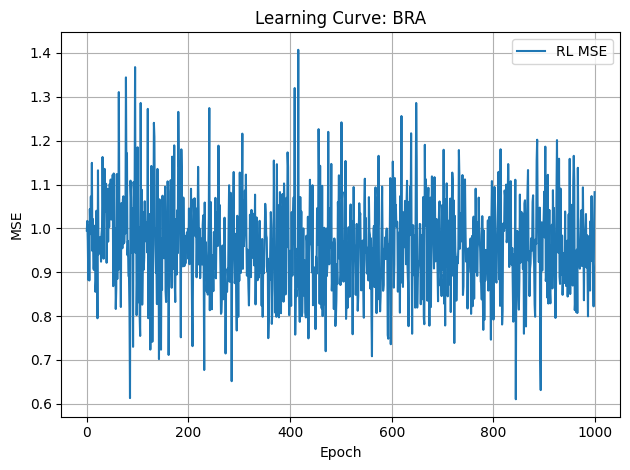

✅ Plot saved to results/quarterly/figures/BRA_donors_probabilities.pdf


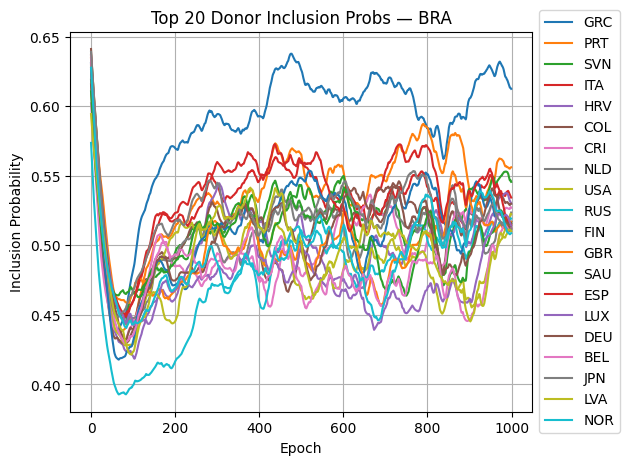

📦 Loaded results_FRA.pkl
✅ Plot saved to results/quarterly/figures/FRA_learning_curve.pdf


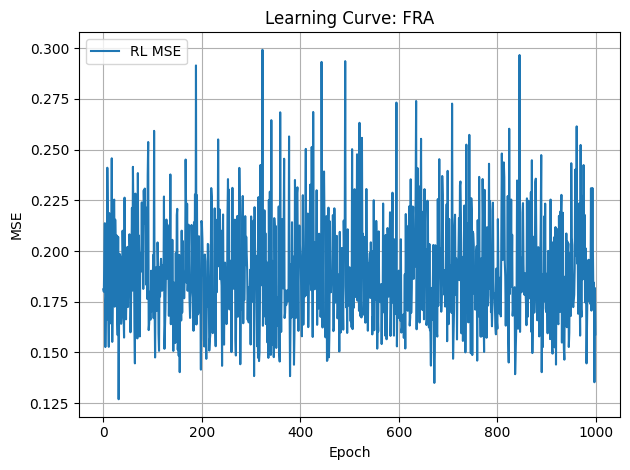

✅ Plot saved to results/quarterly/figures/FRA_donors_probabilities.pdf


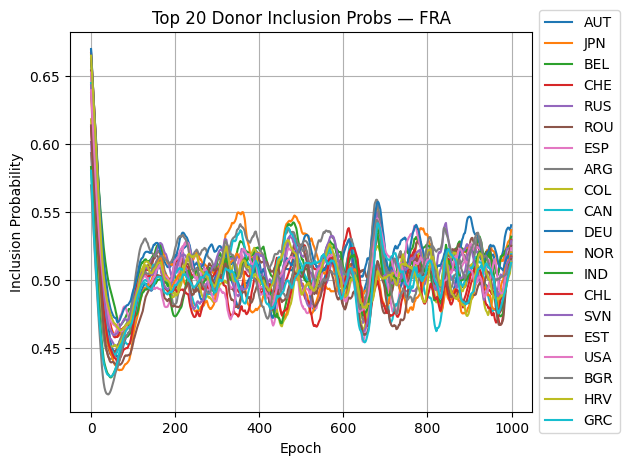

📦 Loaded results_BEL.pkl
✅ Plot saved to results/quarterly/figures/BEL_learning_curve.pdf


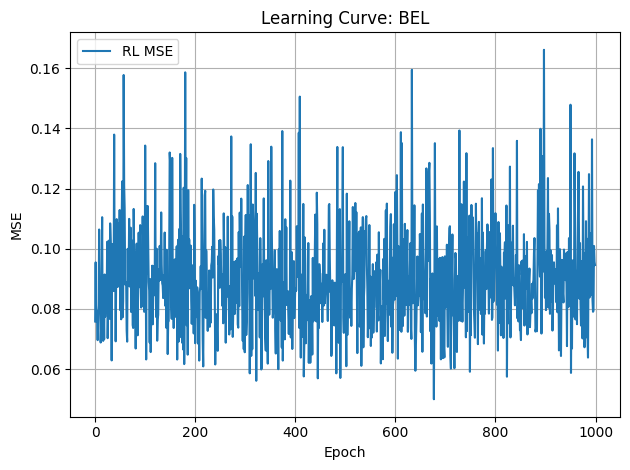

✅ Plot saved to results/quarterly/figures/BEL_donors_probabilities.pdf


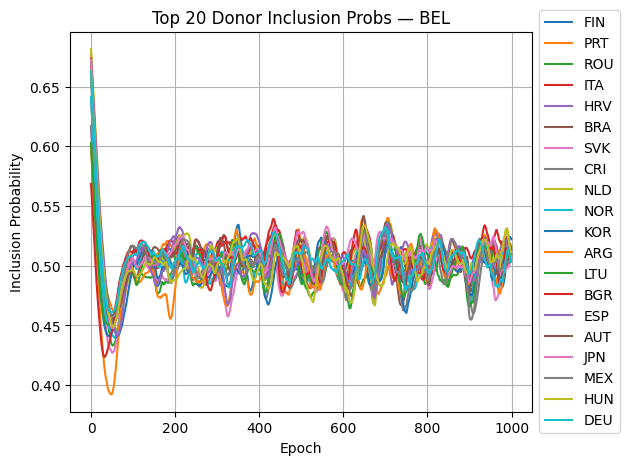

📦 Loaded results_ARG.pkl
✅ Plot saved to results/quarterly/figures/ARG_learning_curve.pdf


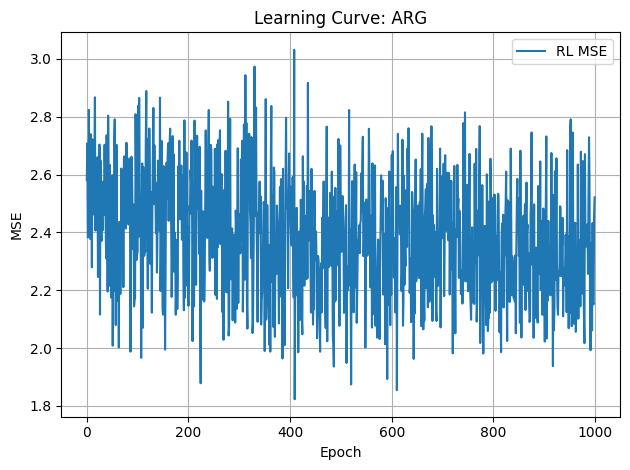

✅ Plot saved to results/quarterly/figures/ARG_donors_probabilities.pdf


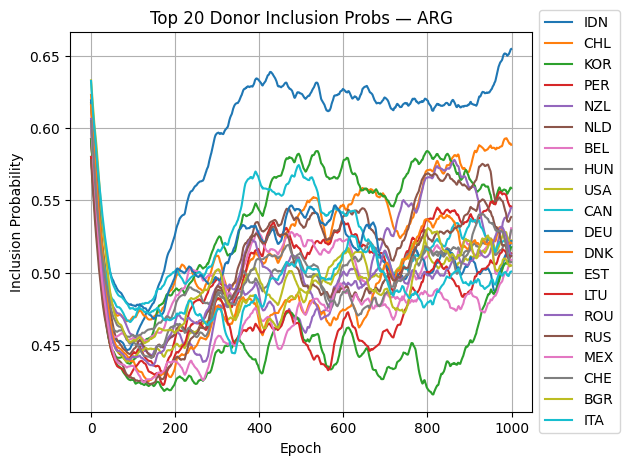

📦 Loaded results_PER.pkl
✅ Plot saved to results/quarterly/figures/PER_learning_curve.pdf


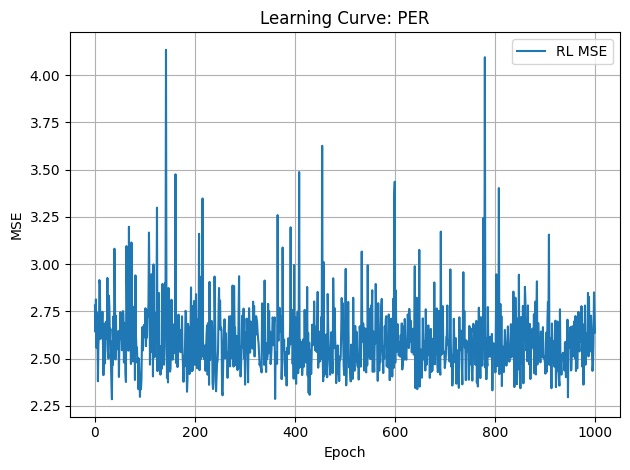

✅ Plot saved to results/quarterly/figures/PER_donors_probabilities.pdf


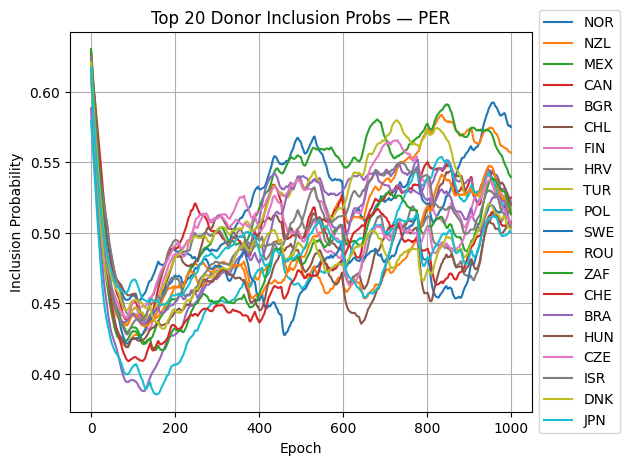

📦 Loaded results_ESP.pkl
✅ Plot saved to results/quarterly/figures/ESP_learning_curve.pdf


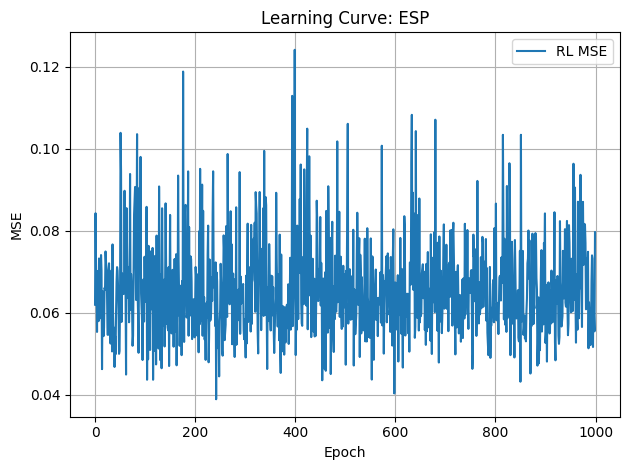

✅ Plot saved to results/quarterly/figures/ESP_donors_probabilities.pdf


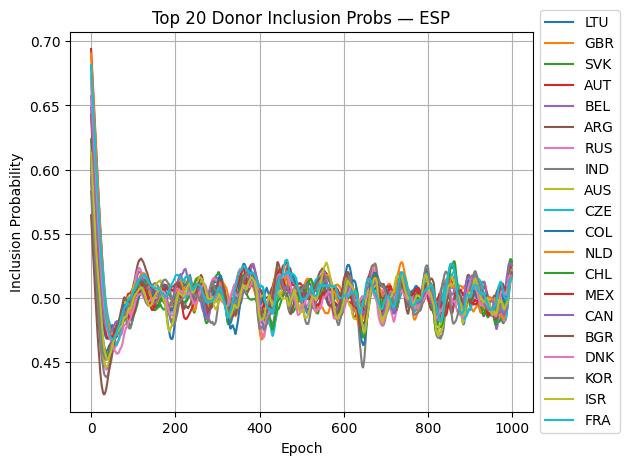

📦 Loaded results_USA.pkl
✅ Plot saved to results/quarterly/figures/USA_learning_curve.pdf


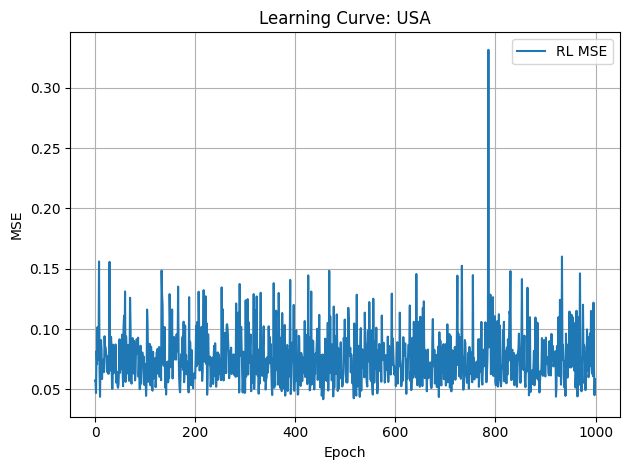

✅ Plot saved to results/quarterly/figures/USA_donors_probabilities.pdf


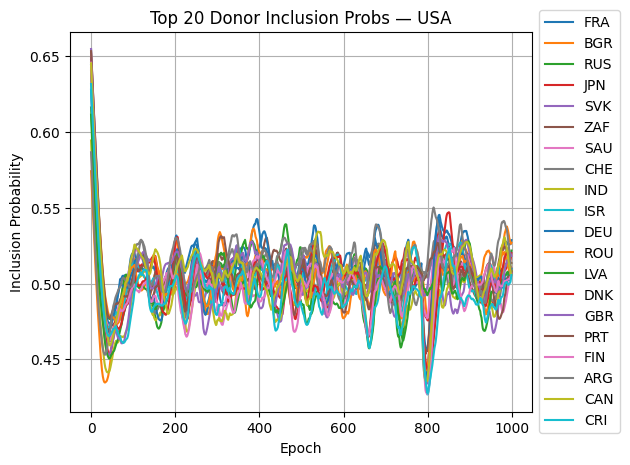

📦 Loaded results_ITA.pkl
✅ Plot saved to results/quarterly/figures/ITA_learning_curve.pdf


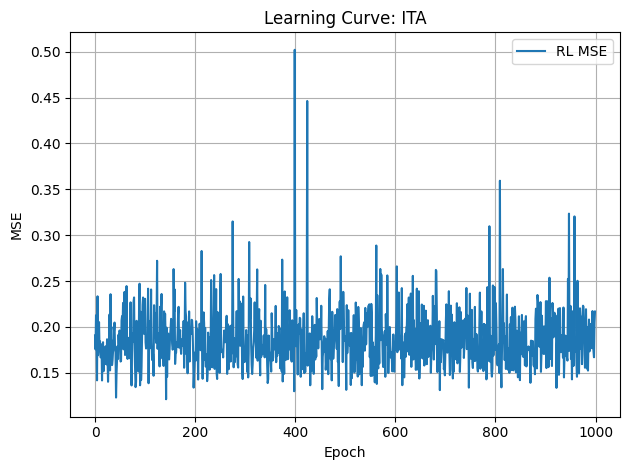

✅ Plot saved to results/quarterly/figures/ITA_donors_probabilities.pdf


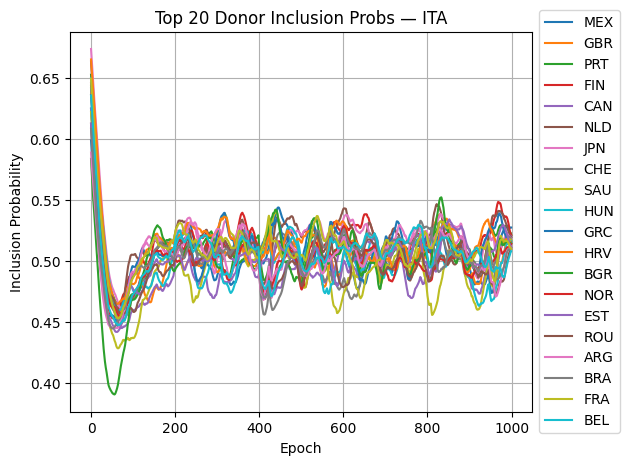

📦 Loaded results_CZE.pkl
✅ Plot saved to results/quarterly/figures/CZE_learning_curve.pdf


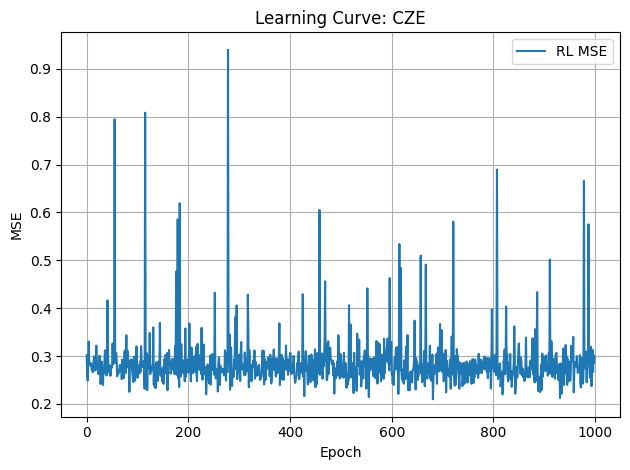

✅ Plot saved to results/quarterly/figures/CZE_donors_probabilities.pdf


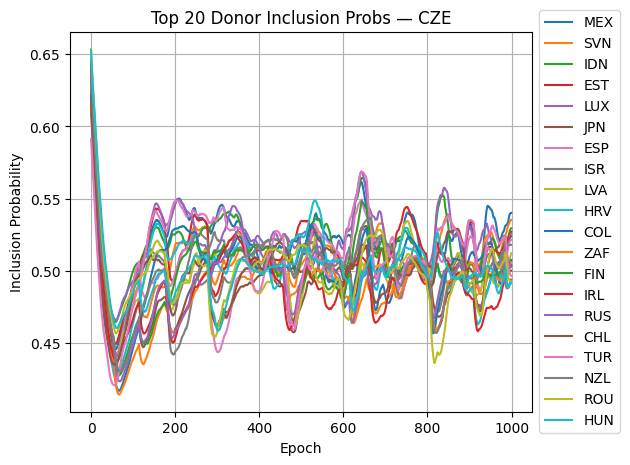

📦 Loaded results_DEU.pkl
✅ Plot saved to results/quarterly/figures/DEU_learning_curve.pdf


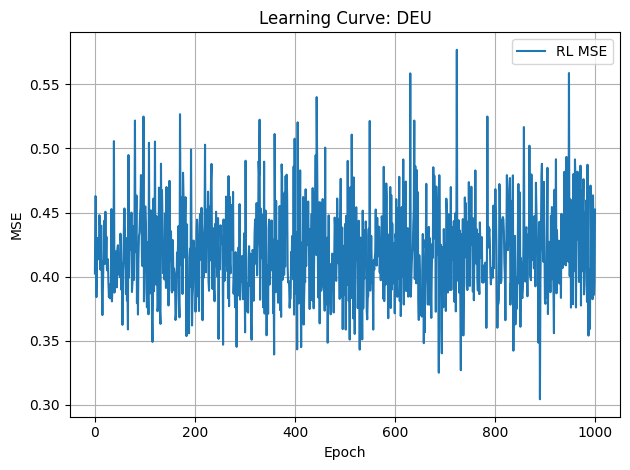

✅ Plot saved to results/quarterly/figures/DEU_donors_probabilities.pdf


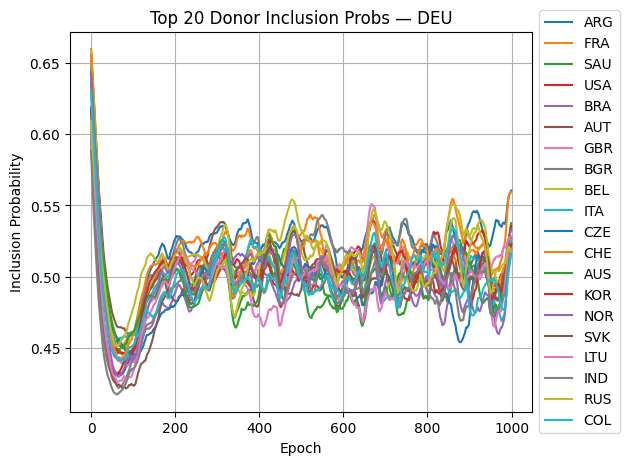

✅ Plot saved to results/quarterly/figures/summary_plot.pdf


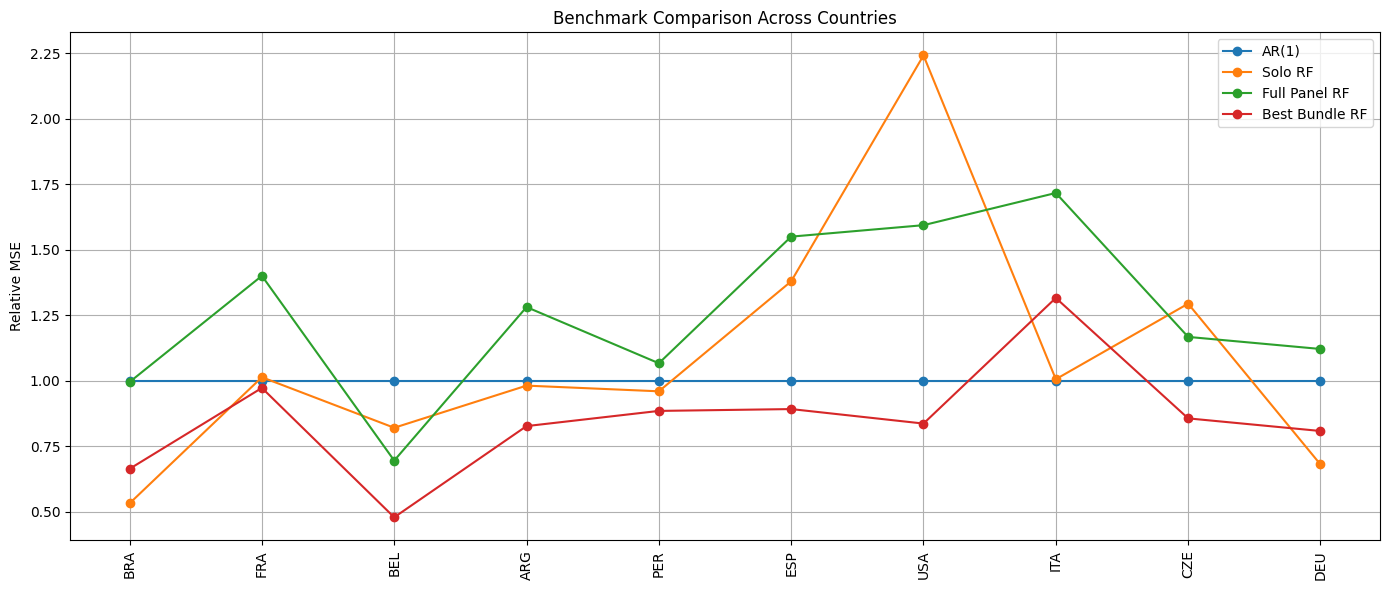

✅ Boxplot saved to results/quarterly/figures/mse_boxplot.pdf


/tmp/ipykernel_111332/3271822040.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Method", y="Relative MSE", palette="Set2")


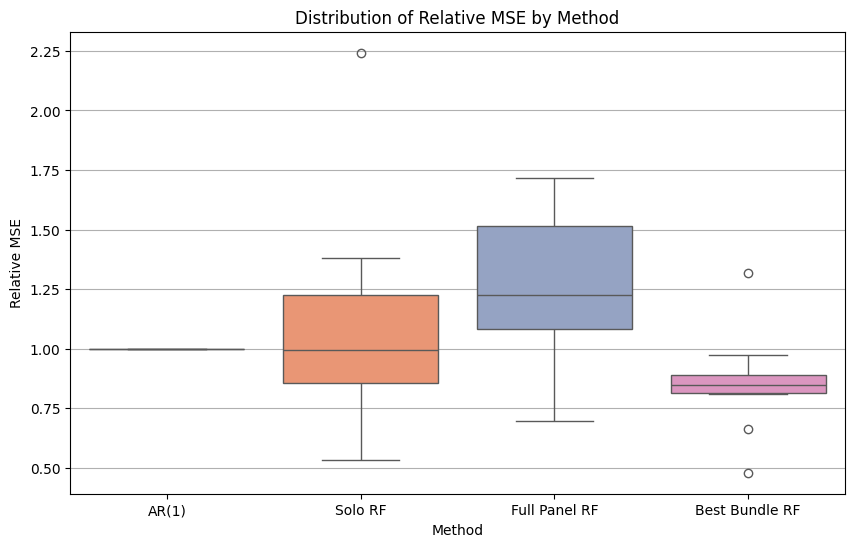

In [4]:
benchmark_df = load_results_and_plot(results_dir="results/quarterly", top_n_donors=20, save=True, directory="results/quarterly/figures")
plot_benchmark_summary(benchmark_df, save=True, save_path="results/quarterly/figures/summary_plot.pdf")
plot_benchmark_boxplot(benchmark_df, save=True, save_path="results/quarterly/figures/mse_boxplot.pdf")

In [5]:
df_relative = benchmark_df.copy()
for idx, row in df_relative.iterrows():
    ar1_mse = row["AR(1)"]
    if ar1_mse == 0:
        continue  # avoid division by zero
    for col in df_relative.columns:
        if col != "country":
            df_relative.at[idx, col] = row[col] / ar1_mse
    df_relative.at[idx, "AR(1)"] = 1.0  # set AR(1) to baseline

df_relative.sort_values(by="country", inplace=True, ignore_index=True)
df_relative

,country,AR(1),Solo RF,Full Panel RF,Best Bundle RF
0,ARG,1.0,0.982293,1.282057,0.827808
1,BEL,1.0,0.821441,0.696261,0.479734
2,BRA,1.0,0.532891,0.996017,0.664733
3,CZE,1.0,1.295009,1.168212,0.857316
4,DEU,1.0,0.681463,1.122137,0.809127
5,ESP,1.0,1.380276,1.550887,0.892787
6,FRA,1.0,1.014324,1.401249,0.973489
7,ITA,1.0,1.006707,1.717486,1.316925
8,PER,1.0,0.960581,1.067646,0.885781
9,USA,1.0,2.242412,1.594578,0.837488


In [6]:
df_relative.describe().T

,count,mean,std,min,25%,50%,75%,max
AR(1),10.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Solo RF,10.0,1.091740,0.476646,0.532891,0.856226,0.994500,1.224838,2.242412
Full Panel RF,10.0,1.259653,0.312376,0.696261,1.081269,1.225135,1.513477,1.717486
Best Bundle RF,10.0,0.854519,0.213429,0.479734,0.813797,0.847402,0.891036,1.316925


In [11]:
results_dir="results/quarterly"

for filename in os.listdir(results_dir):
    if filename.endswith(".pkl") and filename.startswith("results_"):
        filepath = os.path.join(results_dir, filename)
        with open(filepath, "rb") as f:
            results = pickle.load(f)

        top_bundles = results["top_bundles"]
        target_unit = results["target_unit"]
        top_k = 1
        for rank, (mse, bundle, epoch) in enumerate(top_bundles[:top_k], 1):
            print(f"{rank}. Country: {target_unit}, MSE: {mse:.4f}, Bundle Size: {len(bundle)}, Bundle: {bundle}")

1. Country: BRA, MSE: 0.6105, Bundle Size: 17, Bundle: ['JPN', 'BEL', 'SWE', 'GBR', 'PRT', 'CHE', 'GRC', 'DNK', 'NLD', 'HUN', 'CZE', 'SVN', 'EST', 'COL', 'ISR', 'CRI', 'RUS']
1. Country: FRA, MSE: 0.1269, Bundle Size: 21, Bundle: ['DEU', 'JPN', 'HRV', 'FIN', 'BEL', 'ITA', 'CZE', 'NLD', 'ESP', 'CAN', 'POL', 'BRA', 'COL', 'IDN', 'CRI', 'ISR', 'CHL', 'RUS', 'LTU', 'IND', 'GRC']
1. Country: BEL, MSE: 0.0500, Bundle Size: 23, Bundle: ['FRA', 'NLD', 'CZE', 'JPN', 'ESP', 'SWE', 'CHE', 'ITA', 'HRV', 'DEU', 'CAN', 'SAU', 'MEX', 'ISL', 'NOR', 'BRA', 'POL', 'GRC', 'EST', 'RUS', 'LTU', 'IND', 'BGR']
1. Country: ARG, MSE: 1.8233, Bundle Size: 20, Bundle: ['HRV', 'CHL', 'FRA', 'DEU', 'DNK', 'CZE', 'SWE', 'AUT', 'ROU', 'CAN', 'HUN', 'AUS', 'COL', 'LUX', 'PER', 'EST', 'IDN', 'SAU', 'KOR', 'RUS']
1. Country: PER, MSE: 2.2853, Bundle Size: 22, Bundle: ['IRL', 'ZAF', 'LUX', 'NOR', 'BEL', 'CHE', 'IDN', 'HUN', 'BRA', 'FIN', 'CAN', 'GBR', 'CRI', 'MEX', 'ROU', 'CZE', 'KOR', 'DEU', 'HRV', 'ITA', 'GRC', 'ARG']